In [64]:
import os
import sys
import numpy as np
import torch
from glob import glob
import scprep
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import wandb

sys.path.append('../../src/')
from model2 import Autoencoder, Discriminator
from off_manifolder import offmanifolder_maker_new
from geodesic import GeodesicFM

In [65]:
# # Or, remotely load model from wandb
# wandb.login()
# api = wandb.Api()

### Load GAGA Encoder
Note: the encoder takes in unnormalized data and then apply normalization by default.

In [66]:
local=False
root_dir = '../../'

if local:
    # Load model from wandb run checkpoint
    run_path = os.path.join(root_dir, 'src/wandb/run-20240709_172630-pdsufcya')
else:
    entity = 'xingzhis'
    project = 'dmae'
    run_id = 'pzlwi6t6' # run id of the model. This can be found in the wandb url of the run.
    # run = api.run(f"{entity}/{project}/{run_id}")
    # print(run.__dict__)
    # for k,v in run.config.items():
    #     print(k, v)
    run_path = os.path.join(root_dir, 'src/wandb/')
    run_path = glob(f"{run_path}/*{run_id}")[0]
    print(run_path)

model_path = glob(f"{run_path}/files/*.ckpt")[0]
print(model_path)

ae_model = Autoencoder.load_from_checkpoint(model_path)
print(ae_model)


Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../src/wandb/run-20240502_001829-pzlwi6t6/files/epoch=24-step=48000.ckpt`


../../src/wandb/run-20240502_001829-pzlwi6t6
../../src/wandb/run-20240502_001829-pzlwi6t6/files/epoch=24-step=48000.ckpt
Autoencoder(
  (encoder): Encoder(
    (preprocessor): Preprocessor()
    (mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=3, bias=True)
      )
    )
  )
  (decoder): Decoder(
    (preprocessor): Preprocessor()
    (mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=3, out_features=64, 

/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [67]:
# Load config
config = ae_model.hparams.cfg
for k, v in config.items():
    print(f'{k}: {v}')


dimensions: {'latent': 3, 'data': 50}
encoder: {'layer_widths': [256, 128, 64], 'activation': 'relu', 'batch_norm': True, 'dropout': 0}
decoder: {'layer_widths': [64, 128, 256], 'activation': 'relu', 'batch_norm': True, 'dropout': 0.2}
training: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 256, 'monitor': 'validation/loss', 'patience': 50, 'accelerator': 'cuda', 'log_every_n_steps': 100, 'max_epochs': 50, 'train_valid_split': 0.8, 'seed': 42, 'shuffle': True, 'mode': 'end2end'}
loss: {'dist_mse_decay': 0.5, 'weights': {'dist': 77.4, 'reconstr': 0.32, 'cycle': 1, 'cycle_dist': 0, 'negative': 0.0}}
path: {'root': '../results/', 'model': 'model', 'log': ''}
data: {'root': '../data/', 'filetype': '.npz', 'name': 'eb_subset_all'}
logger: {'use_wandb': True, 'entity': 'xingzhis', 'project': 'dmae', 'tags': ['default']}


In [68]:
# Load data
data_path = os.path.join('../', os.path.join(config.data['root'], config.data['name']) +  config.data['filetype'])
print(data_path)
data = np.load(data_path)

print('Loaded data:')
for files in data.files:
    print(files, data[files].shape, data[files].dtype)

../../data/eb_subset_all.npz
Loaded data:
data (3000, 50) float32
phate (3000, 2) float64
dist (3000, 3000) float64
colors (3000,) int64
is_train (3000,) bool


encodings.shape:  (3000, 3)
x_phate.shape:  (3000, 2)


<Axes: title={'center': 'GAGA'}, xlabel='GAGA1', ylabel='GAGA2'>

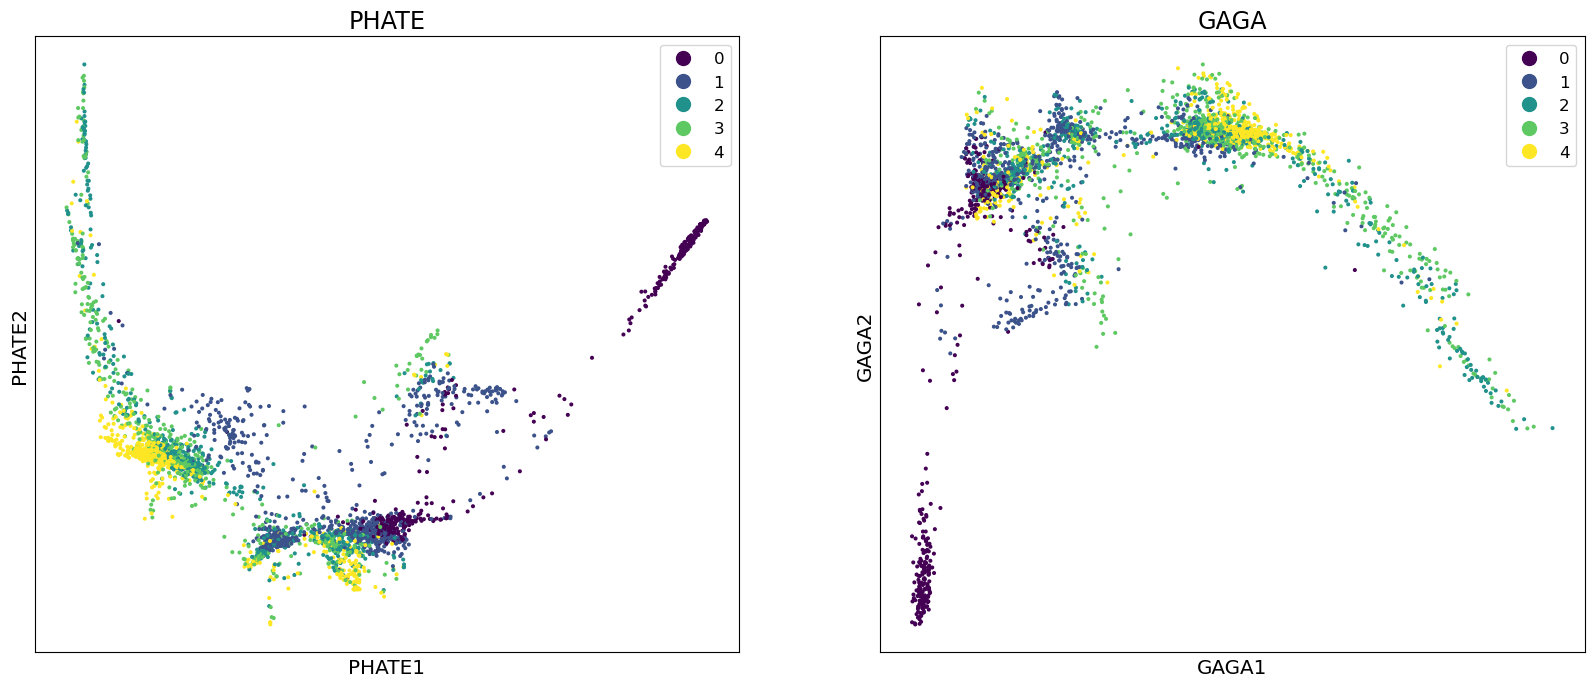

In [69]:
# Sanity check encoder and decoder on data.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = 'mps'

x = data['data']
batch_size = 32

# Encode data
encodings = []
ae_model = ae_model.to(device)
ae_model.eval()
with torch.no_grad():
    for i in range(0, len(x), batch_size):
        x_batch = torch.tensor(x[i:i+batch_size], dtype=torch.float32).to(device)
        encodings.append(ae_model.encoder(x_batch).cpu().detach().numpy())
encodings = np.concatenate(encodings, axis=0)
print('encodings.shape: ', encodings.shape)

x_phate = data['phate']
print('x_phate.shape: ', x_phate.shape)

# Plot
fig = plt.figure(figsize=(10*2, 8))
ax = fig.add_subplot(121)
scprep.plot.scatter2d(x_phate, c=data['colors'], cmap='viridis', ticks=False, label_prefix='PHATE', title='PHATE', ax=ax)
ax = fig.add_subplot(122)
scprep.plot.scatter2d(encodings, c=data['colors'], cmap='viridis', ticks=False, label_prefix='GAGA', title='GAGA', ax=ax)


In [70]:
# Plotly
import plotly
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=encodings[:,0], y=encodings[:,1], z=encodings[:,2], 
                           mode='markers', marker=dict(size=2, color=data['colors'], colorscale='Viridis', opacity=0.8)))

In [71]:
np.sum(data['is_train'])

2400

### Load Wasserstein Discriminator

In [72]:
local=False
if local == True:
    # Load model.
    wd_run_path = os.path.join(root_dir, 'src/wandb/run-20240713_163458-vkfmju0p/files')
else:
    # Or remotely load model from wandb
    entity = 'xingzhis'
    project = 'dmae'
    run_id = 'kafcutw4'
    # run = api.run(f"{entity}/{project}/{run_id}")
    # cfg = run.config
    # print(cfg)
    wd_run_path = os.path.join(root_dir, 'src/wandb/')
    wd_run_path = glob(f"{wd_run_path}/*{run_id}")[0]
    print(wd_run_path)
print(wd_run_path)
wd_model_path = glob(f"{wd_run_path}/files/*.ckpt")[0]
print(wd_model_path)

wd_model = Discriminator.load_from_checkpoint(wd_model_path)
print(wd_model)

# Load config.
config = wd_model.hparams.cfg
for k, v in config.items():
    print(f'{k}: {v}')

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../src/wandb/run-20240502_013119-kafcutw4/files/epoch=6-step=26880.ckpt`


../../src/wandb/run-20240502_013119-kafcutw4
../../src/wandb/run-20240502_013119-kafcutw4
../../src/wandb/run-20240502_013119-kafcutw4/files/epoch=6-step=26880.ckpt
Discriminator(
  (preprocessor): Preprocessor()
  (mlp): MLP(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=128, out_features=64, bias=True)
      (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
      (12): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
dimensions: {'latent': 2, 'data'

/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [73]:
# Load data
wd_data_path = f"{config.data['root']}/{config.data['name']}{config.data['filetype']}"
wd_data_path = os.path.join('../', wd_data_path)
print(wd_data_path)

wd_data = np.load(wd_data_path)
print('Loaded data:')
for files in wd_data.files:
    print(files, wd_data[files].shape, wd_data[files].dtype)

../../data/negative_sampling_toy_shell/False//eb.npz
Loaded data:
data (5400, 50) float64
phate (5400, 2) float64
dist (5400, 5400) float64
colors (5400,) float64
is_train (5400,) float64
mask_x (5400,) float64
mask_d (5400, 5400) float32


probs.shape:  (5400,)
wd_x_phate.shape:  (5400, 2)


<Axes: title={'center': 'PHATE'}, xlabel='PHATE1', ylabel='PHATE2'>

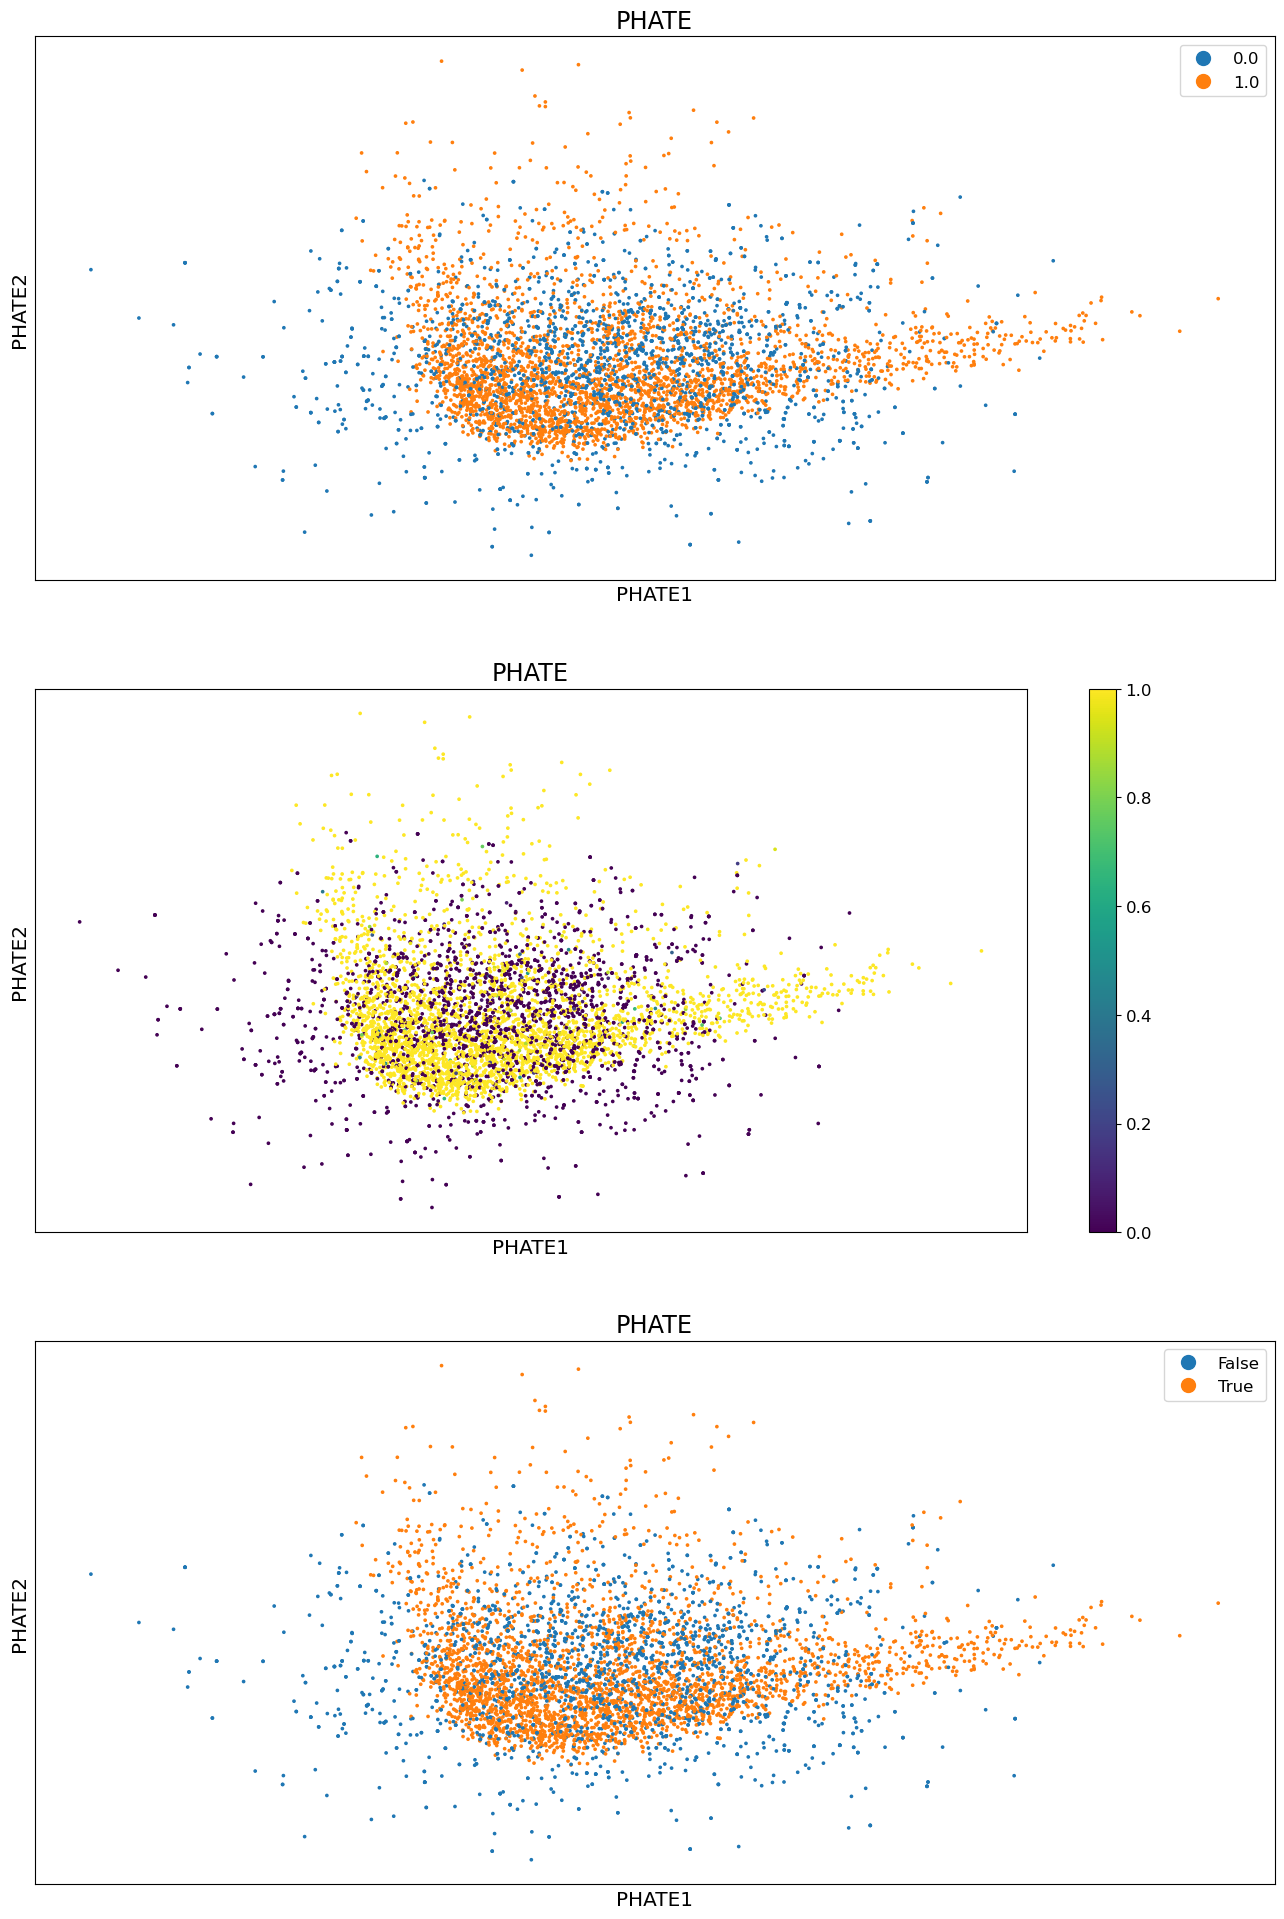

In [74]:
# Sanity check discriminator on data.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = 'mps'

wd_x = wd_data['data']
wd_batch_size = 32
probs = []
wd_model = wd_model.to(device)
wd_model.eval()
with torch.no_grad():
    for i in range(0, len(wd_x), wd_batch_size):
        x_batch = torch.tensor(wd_x[i:i+wd_batch_size], dtype=torch.float32).to(device)
        #prob = wd_model(x_batch)[:, 1] # probability of being real
        prob = wd_model.positive_proba(x_batch)
        probs.append(prob.cpu().detach().numpy())
probs = np.concatenate(probs, axis=0)
print('probs.shape: ', probs.shape)

wd_x_phate = wd_data['phate']
print('wd_x_phate.shape: ', wd_x_phate.shape)

# Plot
fig = plt.figure(figsize=(16, 8*3))
ax = fig.add_subplot(311)
scprep.plot.scatter2d(wd_x, c=wd_data['mask_x'], ticks=False, label_prefix='PHATE', title='PHATE', ax=ax)
ax = fig.add_subplot(312)
scprep.plot.scatter2d(wd_x, c=probs, cmap='viridis', ticks=False, label_prefix='PHATE', title='PHATE', ax=ax)
ax = fig.add_subplot(313)
scprep.plot.scatter2d(wd_x, c=probs > 0.5, ticks=False, label_prefix='PHATE', title='PHATE', ax=ax)


In [75]:
wd_encodings = []
ae_model = ae_model.to(device)
ae_model.eval()
with torch.no_grad():
    for i in range(0, len(wd_x), wd_batch_size):
        x_batch = torch.tensor(wd_x[i:i+wd_batch_size], dtype=torch.float32).to(device)
        wd_encodings.append(ae_model.encoder(x_batch).cpu().detach().numpy())
wd_encodings = np.concatenate(wd_encodings, axis=0)
print('wd_encodings.shape: ', wd_encodings.shape)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=wd_encodings[:,0], y=wd_encodings[:,1], z=wd_encodings[:,2],
                           mode='markers', marker=dict(size=2, color=wd_data['mask_x'], colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=wd_encodings[:,0], y=wd_encodings[:,1], z=wd_encodings[:,2],
                            mode='markers', marker=dict(size=2, color=probs, colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=wd_encodings[:,0], y=wd_encodings[:,1], z=wd_encodings[:,2],
                            mode='markers', marker=dict(size=2, color=probs > 0.5, colorscale='Viridis', opacity=0.8)))


wd_encodings.shape:  (5400, 3)


In [76]:
print('The original data x: ', x.shape)

The original data x:  (3000, 50)


### Run geodesic flow matching
1. Define x0, x1 start/end points on ambient data space.
2. Create off_manifolder by passing encoder to encode points both on/off manifold, thus learn a meaningful metric
3. Pass 1)off_manifolder and 2)encoder to GeodesicFM model. Freeze off_manifolder's and encoder's parameters. Encoder is needed for OPT.
4. Train GeodesicFM and infer.

In [87]:
def sample_indices_within_range(points, selected_idx=None, range_size=0.1, num_samples=20, seed=23):
    np.random.seed(seed)
    # Randomly select two points from the array
    if selected_idx is None:
        selected_indices = np.random.choice(points.shape[0], 2, replace=False)
        point1_idx, point2_idx = selected_indices[0], selected_indices[1]
        point1, point2 = points[point1_idx], points[point2_idx]
    else:
        point1_idx, point2_idx = selected_idx
        point1, point2 = points[point1_idx], points[point2_idx]    
    # Function to find indices of points within the range of a given point
    def _find_indices_within_range(point):
        distances = np.linalg.norm(points - point, axis=1)
        within_range_indices = np.where(distances <= range_size)[0]
        return within_range_indices
    
    # Find indices within range of point1 and point2
    indices_within_range1 = _find_indices_within_range(point1)
    indices_within_range2 = _find_indices_within_range(point2)
    
    # Randomly sample indices within the range
    if len(indices_within_range1) >= num_samples:
        sampled_indices_point1 = np.random.choice(indices_within_range1, num_samples, replace=False)
    else:
        sampled_indices_point1 = indices_within_range1
    
    if len(indices_within_range2) >= num_samples:
        sampled_indices_point2 = np.random.choice(indices_within_range2, num_samples, replace=False)
    else:
        sampled_indices_point2 = indices_within_range2
    
    return point1_idx, sampled_indices_point1, point2_idx, sampled_indices_point2

start_group = 0
end_group = 1

start_idices = np.where(data['colors'] == start_group)[0]
start_idx = np.random.choice(start_idices, 1)[0]
end_idices = np.where(data['colors'] == end_group)[0]
end_idx = np.random.choice(end_idices, 1)[0]
print('start_idx, end_idx: ', start_idx, end_idx)

start_idx = 736 
end_idx = 2543

point1_idx, sampled_indices_point1, point2_idx, sampled_indices_point2 = sample_indices_within_range(encodings, 
                                                                                                     selected_idx=(start_idx, end_idx),
                                                                                                     range_size=0.5, 
                                                                                                     seed=2024, num_samples=50)
point1 = x[point1_idx]
point2 = x[point2_idx]
samples_point1 = x[sampled_indices_point1]
samples_point2 = x[sampled_indices_point2]


print('point1, point2: ', point1.shape, point2.shape)
print('samples_point1, samples_point2: ', samples_point1.shape, samples_point2.shape)


start_idx, end_idx:  1196 2177
point1, point2:  (50,) (50,)
samples_point1, samples_point2:  (50, 50) (50, 50)


In [88]:
print('point1, point2: ', point1_idx, point2_idx) # point1, point2: 736 2543 (0-3)

point1, point2:  736 2543


In [89]:
samples_z_point1 = ae_model.encoder(torch.tensor(samples_point1, dtype=torch.float32).to(device)).cpu().detach().numpy()
samples_z_point2 = ae_model.encoder(torch.tensor(samples_point2, dtype=torch.float32).to(device)).cpu().detach().numpy()
start_end_z = np.vstack([encodings[start_idx], encodings[end_idx]])
print('samples_z_point1, samples_z_point2: ', samples_z_point1.shape, samples_z_point2.shape)
print('start_end_z: ', start_end_z.shape)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=encodings[:,0], y=encodings[:,1], z=encodings[:,2], 
                           mode='markers', marker=dict(size=2, color='gray', colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=start_end_z[:,0], y=start_end_z[:,1], z=start_end_z[:,2],
                            mode='markers', marker=dict(size=5, color='red', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point1[:,0], y=samples_z_point1[:,1], z=samples_z_point1[:,2],
                            mode='markers', marker=dict(size=2, color='blue', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point2[:,0], y=samples_z_point2[:,1], z=samples_z_point2[:,2],
                            mode='markers', marker=dict(size=2, color='green', opacity=0.8)))

samples_z_point1, samples_z_point2:  (50, 3) (50, 3)
start_end_z:  (2, 3)


In [90]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x0, x1):
        self.x0 = x0
        self.x1 = x1

    def __len__(self):
        return max(len(self.x0), len(self.x1))

    def __getitem__(self, idx):
        return self.x0[idx % len(self.x0)], self.x1[idx % len(self.x1)]

def custom_collate_fn(batch):
    x0_batch = torch.stack([item[0] for item in batch])
    x1_batch = torch.stack([item[1] for item in batch])
    
    # Randomly permute the elements in the batch
    perm_x0 = torch.randperm(len(x0_batch))
    perm_x1 = torch.randperm(len(x1_batch))

    x0_batch = x0_batch[perm_x0]
    x1_batch = x1_batch[perm_x1]
    
    return x0_batch, x1_batch

# Create a dataloader
dataset = CustomDataset(x0=torch.tensor(samples_point1, dtype=torch.float32), 
                        x1=torch.tensor(samples_point2, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

In [91]:
probs = torch.tensor(probs, dtype=torch.float32).to(device) # the global probability of being real for all x.
max_prob = probs.max()
print('max_prob: ', max_prob)
min_prob = probs.min()
print('min_prob: ', min_prob)
avg_prob = probs.mean()
print('avg_prob: ', avg_prob)

ae_model = ae_model.to(device)
wd_model = wd_model.to(device)

for param in ae_model.encoder.parameters():
    param.requires_grad = False
for param in wd_model.parameters():
    param.requires_grad = False

enc_func = lambda x: ae_model.encoder(x)
#disc_func = lambda x: (wd_model.positive_proba(x) - min_prob) / (max_prob - min_prob) # normalize the probability to [0, 1]
disc_func = lambda x: 1 - wd_model.positive_proba(x)

ofm = offmanifolder_maker_new(enc_func, disc_func, disc_factor=5) # ofm encodes both on/off manifold points
gbmodel = GeodesicFM(
    func=ofm,
    encoder=enc_func,
    input_dim=x.shape[1],
    hidden_dim=64, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=100, 
    lr=1e-3, 
    weight_decay=1e-3,
)

gbmodel.lr=1e-3
trainer = pl.Trainer(
    # logger=logger,
    max_epochs=180,
    log_every_n_steps=20,
    accelerator=device,
)

trainer.fit(gbmodel, dataloader)
checkpoint_dir = './eb_fm/checkpoints'
trainer.save_checkpoint(f"{checkpoint_dir}/{start_group}_{end_group}_gbmodel.ckpt")

/var/folders/hy/gr187tl92q5498xtt4shr0440000gn/T/ipykernel_99566/548228234.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/yale529/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | cc         | CondCurveOverfit | 51.4 K | train
1 | flow_model | MLP              | 14.9 K | train
--------------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params 

max_prob:  tensor(1., device='mps:0')
min_prob:  tensor(8.1045e-26, device='mps:0')
avg_prob:  tensor(0.5570, device='mps:0')
Epoch 179: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=18, loss_length_step=23.60, fm_length_step=3.150, loss_step=26.80, train_loss_step=26.80, loss_length_epoch=12.50, fm_length_epoch=2.980, loss_epoch=15.50, train_loss_epoch=15.50]           

`Trainer.fit` stopped: `max_epochs=180` reached.


Epoch 179: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=18, loss_length_step=23.60, fm_length_step=3.150, loss_step=26.80, train_loss_step=26.80, loss_length_epoch=12.50, fm_length_epoch=2.980, loss_epoch=15.50, train_loss_epoch=15.50]


#### Infer trajectories using GeodesicBridge Model

In [92]:
x0, x1 = next(iter(dataloader))

x0 = x0.to(device)
x1 = x1.to(device)

ids = torch.zeros((x0.size(0),1)) # Conditional id for each pair of x0 and x1, here is a dummy.
ids = ids.to(device)

gbmodel = gbmodel.to(device)
gbmodel.eval()
with torch.no_grad():
    x_traj = gbmodel(x0, x1, gbmodel.ts.to(device), ids) # [T, B, D]
print('Predicted trajectory shape: ', x_traj.shape)

ae_model.eval()
with torch.no_grad():
    z_traj = ae_model.encoder(x_traj.flatten(0,1)) # [T*B, D]

    z0 = ae_model.encoder(x0)
    z1 = ae_model.encoder(x1)

z_traj = z_traj.cpu().detach().numpy()
z_traj = z_traj.reshape(x_traj.size(0), x_traj.size(1), -1)
print('z_traj.shape: ', z_traj.shape)

z0 = z0.cpu().detach().numpy()
z1 = z1.cpu().detach().numpy()

Predicted trajectory shape:  torch.Size([100, 32, 50])
z_traj.shape:  (100, 32, 3)


In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=encodings[:,0], y=encodings[:,1], z=encodings[:,2], 
                           mode='markers', marker=dict(size=2, color='gray', colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point1[:,0], y=samples_z_point1[:,1], z=samples_z_point1[:,2],
                            mode='markers', marker=dict(size=5, color='blue', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point2[:,0], y=samples_z_point2[:,1], z=samples_z_point2[:,2],
                            mode='markers', marker=dict(size=5, color='green', opacity=0.8)))

for i in range(20):
    fig.add_trace(go.Scatter3d(x=z_traj[:,i,0], y=z_traj[:,i,1], z=z_traj[:,i,2],
                               mode='lines', line=dict(width=2, color='blue')))

fig.show()

# save html
fig.write_html(f"./eb_fm/EB_{start_group}_{end_group}_geobridge.html")

#### Infer Trajectories using ODE on vector fields predicted by FM.

In [94]:
import torchdiffeq
from torch import nn

adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

class ODEFuncWrapper(nn.Module):
    def __init__(self, flowmodel):
        super().__init__()
        self.flowmodel = flowmodel
    def forward(self, t, y):
        # Expand t to match the batch size and feature dimension
        t_expanded = t.view(1, 1).expand(y.size(0), 1)
        # Concatenate y and t along the feature dimension
        y_with_t = torch.cat((y, t_expanded), dim=-1)
        return self.flowmodel(y_with_t)

n_samples = min(10, x0.size(0))
sampled_starts = torch.tensor(x[sampled_indices_point1[:n_samples]], dtype=torch.float32).to('cpu')

print(f'Run ODE on {n_samples} samples: {sampled_starts.shape}')
flowfunc = ODEFuncWrapper(gbmodel.flow_model.to('cpu'))
with torch.no_grad():
    traj = odeint(flowfunc, sampled_starts.to('cpu'), gbmodel.ts.to('cpu'))

print('Flow Matching ODE Trajectory shape: ', traj.shape)

ae_model.eval()
with torch.no_grad():
    traj = traj.to(device)
    z_traj = ae_model.encoder(traj.flatten(0,1)) # [T*B, D]

z_traj = z_traj.cpu().detach().numpy()
z_traj = z_traj.reshape(traj.size(0), traj.size(1), -1)
print('z_traj.shape: ', z_traj.shape)


Run ODE on 10 samples: torch.Size([10, 50])
Flow Matching ODE Trajectory shape:  torch.Size([100, 10, 50])
z_traj.shape:  (100, 10, 3)


In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=encodings[:,0], y=encodings[:,1], z=encodings[:,2], 
                           mode='markers', marker=dict(size=2, color='gray', colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point1[:,0], y=samples_z_point1[:,1], z=samples_z_point1[:,2],
                            mode='markers', marker=dict(size=5, color='blue', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point2[:,0], y=samples_z_point2[:,1], z=samples_z_point2[:,2],
                            mode='markers', marker=dict(size=5, color='green', opacity=0.8)))

for i in range(n_samples):
    fig.add_trace(go.Scatter3d(x=z_traj[:,i,0], y=z_traj[:,i,1], z=z_traj[:,i,2],
                                 mode='lines', line=dict(width=2, color='blue')))

fig.show()

# save the html
fig.write_html(f"./eb_fm/EB_{start_group}_{end_group}_3d.html")

In [96]:
# Plot 2d
fig = go.Figure()
fig.add_trace(go.Scatter(x=encodings[:,0], y=encodings[:,1], mode='markers', marker=dict(size=2, color='gray')))
fig.add_trace(go.Scatter(x=samples_z_point1[:,0], y=samples_z_point1[:,1], mode='markers', marker=dict(size=5, color='blue')))
fig.add_trace(go.Scatter(x=samples_z_point2[:,0], y=samples_z_point2[:,1], mode='markers', marker=dict(size=5, color='green')))
for i in range(n_samples):
    fig.add_trace(go.Scatter(x=z_traj[:,i,0], y=z_traj[:,i,1], mode='lines', line=dict(width=2, color='blue')))
fig.show()

# save html
fig.write_html(f"./eb_fm/EB_{start_group}_{end_group}_2d.html")

In [100]:
# Plot positive_prob of these trajectories
traj.shape # [T, B, D]
traj_flat = traj.flatten(0,1) # [T*B, D]

bs = 32
traj_probs = []
wd_model = wd_model.to(device)
wd_model.eval()
with torch.no_grad():
    for i in range(0, traj_flat.shape[0], bs):
        x_batch = traj_flat[i:i+bs]
        prob = wd_model.positive_proba(x_batch)
        traj_probs.append(prob.cpu().detach().numpy())
traj_probs = np.concatenate(traj_probs, axis=0) # [T*B]
traj_probs = traj_probs.reshape(traj.size(0), traj.size(1)) # [T, B]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=encodings[:,0], y=encodings[:,1], z=encodings[:,2], 
                           mode='markers', marker=dict(size=2, color='gray', colorscale='Viridis', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point1[:,0], y=samples_z_point1[:,1], z=samples_z_point1[:,2],
                            mode='markers', marker=dict(size=5, color='blue', opacity=0.8)))
fig.add_trace(go.Scatter3d(x=samples_z_point2[:,0], y=samples_z_point2[:,1], z=samples_z_point2[:,2],
                            mode='markers', marker=dict(size=5, color='green', opacity=0.8)))

for i in range(n_samples):
    fig.add_trace(go.Scatter3d(x=z_traj[:,i,0], y=z_traj[:,i,1], z=z_traj[:,i,2],
                                 mode='lines', line=dict(width=2, color=traj_probs[:,i], colorscale='Viridis'),
                                 text=[f'Prob: {p:.2f}' for p in traj_probs[:,i]]))

# annotate points with probability



fig.show()

: 